In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, detrend, welch, spectrogram, find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

# Plotting style configuration
plt.style.use('seaborn-v0_8-whitegrid')

In [53]:
# --- CONFIGURATION PARAMETERS ---

# Define where the CSV files are located
DATA_DIR = 'data'

FILE_CONFIG = {
    '2s': [
        os.path.join(DATA_DIR, '2s_sample_01.csv'),
        os.path.join(DATA_DIR, '2s_sample_02.csv'),
        os.path.join(DATA_DIR, '2s_sample_03.csv'),
        os.path.join(DATA_DIR, '2s_sample_04.csv'),
    ],
    '4s': [
        os.path.join(DATA_DIR, '4s_sample_01.csv'),
        os.path.join(DATA_DIR, '4s_sample_02.csv'),
        os.path.join(DATA_DIR, '4s_sample_03.csv'),
        os.path.join(DATA_DIR, '4s_sample_04.csv'),
    ],
    '8s': [
        os.path.join(DATA_DIR, '8s_sample_01.csv'),
        os.path.join(DATA_DIR, '8s_sample_02.csv'),
        os.path.join(DATA_DIR, '8s_sample_03.csv'),
        os.path.join(DATA_DIR, '8s_sample_04.csv'),
    ],
    'spont': [
        os.path.join(DATA_DIR, 'spont_sample_01.csv'),
        os.path.join(DATA_DIR, 'spont_sample_02.csv'),
        os.path.join(DATA_DIR, 'spont_sample_03.csv'),
        os.path.join(DATA_DIR, 'spont_sample_04.csv'),
        os.path.join(DATA_DIR, 'spont_sample_05.csv'),
    ]
}

# Pre-processing constants
TRIM_START = 10
TRIM_END = 10

# Frequency bands
RR_BAND = [0.08, 0.6]  # Respiration: 4.8 - 36 BPM
HR_BAND = [0.8, 2.5]   # Heart Rate: 48 - 150 BPM

In [54]:
# --- SIGNAL PROCESSING FUNCTIONS ---

def load_and_prep_file(filename):
    """
    Loads CSV data, parses timestamps, trims the start/end,
    and detrends the accelerometer signals.
    """
    try:
        df = pd.read_csv(filename)
    except Exception as e:
        print(f"Warning: Could not load {filename}. Error: {e}")
        return None, None

    # Timestamp conversion and relative time calculation
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='mixed')
    start_time = df['Timestamp'].iloc[0]
    df['time'] = (df['Timestamp'] - start_time).dt.total_seconds()

    # Trim transition periods
    time_max = df['time'].max()
    time_min = df['time'].min()
    df_trimmed = df[(df['time'] >= time_min + TRIM_START) & (df['time'] <= time_max - TRIM_END)].copy()

    if df_trimmed.empty:
        return None, None

    # Calculate Sampling Frequency (Fs)
    fs = 1.0 / np.mean(np.diff(df_trimmed['time']))

    # Detrend data to remove static gravity component
    data = {
        'time': df_trimmed['time'].values,
        'ax': detrend(df_trimmed['X'].values),
        'ay': detrend(df_trimmed['Y'].values),
        'az': detrend(df_trimmed['Z'].values),
        'raw_z': df_trimmed['Z'].values
    }
    return data, fs

def get_pca_signal(data):
    """
    Applies PCA to combine 3-axis accelerometer data into a single principal component.
    """
    scaler = StandardScaler()
    xyz = np.array([data['ax'], data['ay'], data['az']]).T
    scaled = scaler.fit_transform(xyz)
    pca = PCA(n_components=1)
    return pca.fit_transform(scaled).ravel()

def find_psd_peak(psd, freqs, band):
    """
    Identifies the dominant frequency within a specified band using PSD.
    Returns value in BPM.
    """
    mask = (freqs >= band[0]) & (freqs <= band[1])
    if not np.any(mask):
        return 0
    peak_freq = freqs[mask][np.argmax(psd[mask])]
    return peak_freq * 60

def get_time_domain_rate(signal, fs, band, prominence_factor=0.4):
    """
    Calculates BPM using time-domain peak detection with artifact rejection.
    Includes adaptive amplitude thresholding and dynamic interval filtering.
    """
    # Minimum distance based on upper frequency bound
    min_dist_samples = int(fs * (1.0 / band[1]))

    # Initial peak detection
    base_threshold = np.percentile(signal, 75) * prominence_factor
    peaks, properties = find_peaks(signal, distance=min_dist_samples, prominence=base_threshold, height=-np.inf)

    if len(peaks) < 3:
        return np.nan, []

    # Amplitude filtering (reject outliers)
    peak_heights = properties['peak_heights']
    median_height = np.median(peak_heights)

    max_height = median_height * 5.0
    min_height = median_height * 0.4

    valid_peaks = peaks[(peak_heights >= min_height) & (peak_heights <= max_height)]

    if len(valid_peaks) < 2:
        return np.nan, []

    # Dynamic Interval Filtering
    diffs_seconds = np.diff(valid_peaks) / fs

    # Allow 20% margin on band limits for interval validity
    min_interval = (1.0 / band[1]) * 0.8
    max_interval = (1.0 / band[0]) * 1.2

    valid_diffs = diffs_seconds[(diffs_seconds >= min_interval) & (diffs_seconds <= max_interval)]

    if len(valid_diffs) < 1:
        return np.nan, valid_peaks

    bpm = 60.0 / np.mean(valid_diffs)
    return bpm, valid_peaks

In [55]:
# --- BATCH PROCESSING AND ANALYSIS ---

all_results = []

print("Processing files...")

for exp_type, filenames in FILE_CONFIG.items():
    for filename in filenames:
        if not os.path.exists(filename):
            continue

        data, fs = load_and_prep_file(filename)
        if data is None:
            continue

        # 1. Signal Extraction (PCA)
        pca_sig = get_pca_signal(data)

        # 2. Filtering
        # Respiration Filter
        b_rr, a_rr = butter(2, [RR_BAND[0]/(0.5*fs), RR_BAND[1]/(0.5*fs)], btype='band')
        rr_sig = filtfilt(b_rr, a_rr, pca_sig)

        # Heart Rate Filter
        b_hr, a_hr = butter(2, [HR_BAND[0]/(0.5*fs), HR_BAND[1]/(0.5*fs)], btype='band')
        hr_sig = filtfilt(b_hr, a_hr, pca_sig)

        # 3. Time Domain Analysis
        rr_time_bpm, _ = get_time_domain_rate(rr_sig, fs, RR_BAND, prominence_factor=0.5)
        hr_time_bpm, _ = get_time_domain_rate(hr_sig, fs, HR_BAND, prominence_factor=0.4)

        # 4. Frequency Domain Analysis (Welch)
        nperseg = int(fs * 30)
        f_w, psd_rr = welch(rr_sig, fs, nperseg=nperseg)
        f_w, psd_hr = welch(hr_sig, fs, nperseg=nperseg)

        res = {
            'type': exp_type,
            'filename': filename,
            'RR_Welch': find_psd_peak(psd_rr, f_w, RR_BAND),
            'RR_Time': rr_time_bpm,
            'HR_Welch': find_psd_peak(psd_hr, f_w, HR_BAND),
            'HR_Time': hr_time_bpm,
        }
        all_results.append(res)

# Results Aggregation
df_results = pd.DataFrame(all_results).set_index(['type', 'filename'])

print("\n--- Average BPM Results by Experiment Type ---")
print(df_results.groupby('type')[['RR_Welch', 'RR_Time', 'HR_Welch', 'HR_Time']].mean().to_string(float_format="%.2f"))

Processing files...

--- Average BPM Results by Experiment Type ---
       RR_Welch  RR_Time  HR_Welch  HR_Time
type                                       
2s        30.01    25.56     76.01    76.30
4s        14.50    15.06     72.01    74.64
8s         8.00     8.37     70.51    74.30
spont     12.40    14.07     65.61    70.12


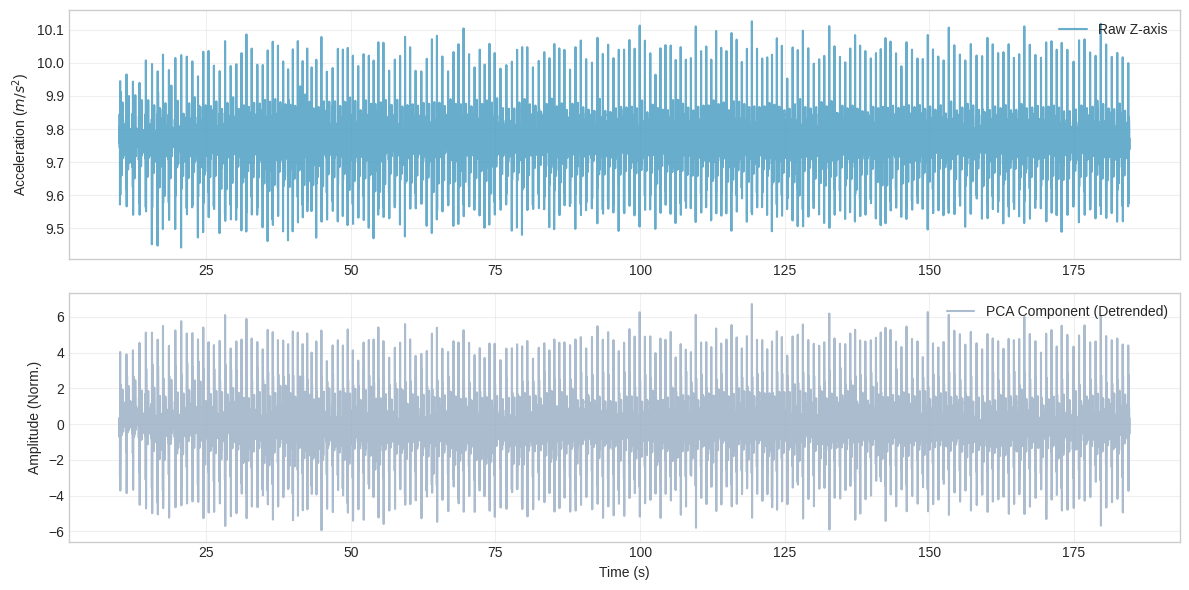

In [56]:
# --- FIGURE 1: SIGNAL PROCESSING STEPS (Raw vs PCA) ---

target_file = 'spont_sample_04.csv'

if os.path.exists(target_file):
    data, fs = load_and_prep_file(target_file)
    pca_sig = get_pca_signal(data)

    plt.figure(figsize=(12, 6))

    # Raw Z-axis
    plt.subplot(2, 1, 1)
    plt.plot(data['time'], data['raw_z'], color='#4399C0', alpha=0.8, label='Raw Z-axis')
    plt.ylabel("Acceleration ($m/s^2$)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    # Detrended PCA
    plt.subplot(2, 1, 2)
    plt.plot(data['time'], pca_sig, color='#98ACC3', alpha=0.8, label='PCA Component (Detrended)')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (Norm.)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("Fig_01_Signal_Processing.png", dpi=150)
    plt.show()

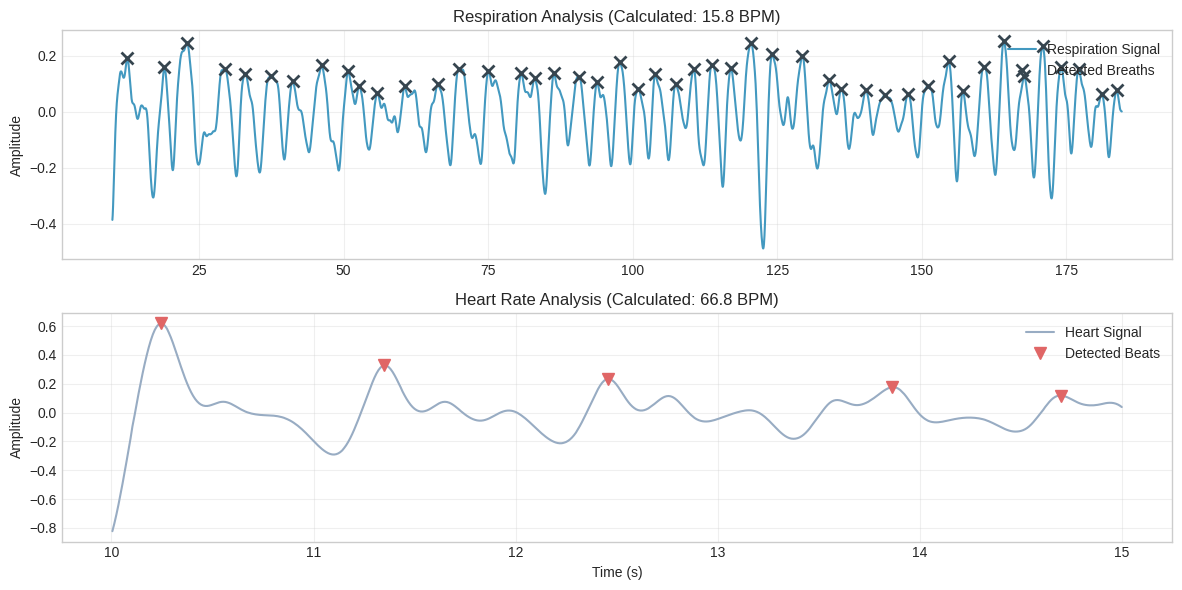

In [57]:
# --- FIGURE 2: TIME DOMAIN VALIDATION (PEAK DETECTION) ---
# This cell should run immediately after Figure 1

# Ensure target file is defined (in case Figure 1 wasn't run immediately before)
target_file = 'spont_sample_04.csv'

if os.path.exists(target_file):
    data, fs = load_and_prep_file(target_file)
    pca_sig = get_pca_signal(data)

    # 1. Apply Filters
    b_rr, a_rr = butter(2, [RR_BAND[0]/(0.5*fs), RR_BAND[1]/(0.5*fs)], btype='band')
    b_hr, a_hr = butter(2, [HR_BAND[0]/(0.5*fs), HR_BAND[1]/(0.5*fs)], btype='band')

    rr_sig = filtfilt(b_rr, a_rr, pca_sig)
    hr_sig = filtfilt(b_hr, a_hr, pca_sig)

    # 2. Detect Peaks (using the robust function)
    rr_bpm, rr_peaks = get_time_domain_rate(rr_sig, fs, RR_BAND, prominence_factor=0.5)
    hr_bpm, hr_peaks = get_time_domain_rate(hr_sig, fs, HR_BAND, prominence_factor=0.4)

    # 3. Plotting
    plt.figure(figsize=(12, 6))

    # Respiration Plot
    plt.subplot(2, 1, 1)
    plt.plot(data['time'], rr_sig, color='#4399C0', label='Respiration Signal')
    plt.plot(data['time'][rr_peaks], rr_sig[rr_peaks], "x", color='#36454F', markersize=8, markeredgewidth=2, label='Detected Breaths')
    plt.title(f"Respiration Analysis (Calculated: {rr_bpm:.1f} BPM)")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    # Heart Rate Plot (Zoomed)
    plt.subplot(2, 1, 2)
    zoom_start, zoom_end = 10, 15
    mask = (data['time'] >= zoom_start) & (data['time'] <= zoom_end)

    plt.plot(data['time'][mask], hr_sig[mask], color='#98ACC3', label='Heart Signal')

    # Filter peaks for the zoomed window
    visible_peaks = [p for p in hr_peaks if zoom_start <= data['time'][p] <= zoom_end]
    plt.plot(data['time'][visible_peaks], hr_sig[visible_peaks], "v", color='#E06666', markersize=8, label='Detected Beats')

    plt.title(f"Heart Rate Analysis (Calculated: {hr_bpm:.1f} BPM)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    # Renamed to Fig_02 to match the new order
    plt.savefig("Fig_02_Time_Domain_Results.png", dpi=150)
    plt.show()

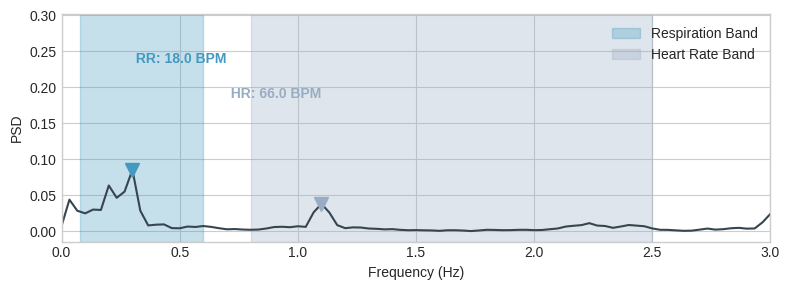

In [58]:
# --- FIGURE 3: FREQUENCY DOMAIN ANALYSIS (PSD) ---

if os.path.exists(target_file):
    # Re-calculate PSD on the full PCA signal for visualization
    nperseg = int(fs * 30)
    f, psd = welch(pca_sig, fs, nperseg=nperseg)

    plt.figure(figsize=(8, 3))
    plt.plot(f, psd, color='#36454F', linewidth=1.5)

    # Highlight Bands
    plt.axvspan(RR_BAND[0], RR_BAND[1], color='#4399C0', alpha=0.3, label='Respiration Band')
    plt.axvspan(HR_BAND[0], HR_BAND[1], color='#98ACC3', alpha=0.3, label='Heart Rate Band')

    # Identify and plot peaks
    rr_mask = (f >= RR_BAND[0]) & (f <= RR_BAND[1])
    hr_mask = (f >= HR_BAND[0]) & (f <= HR_BAND[1])

    rr_peak_idx = np.argmax(psd * rr_mask)
    hr_peak_idx = np.argmax(psd * hr_mask)

    plt.plot(f[rr_peak_idx], psd[rr_peak_idx], 'v', color='#4399C0', markersize=10)
    plt.plot(f[hr_peak_idx], psd[hr_peak_idx], 'v', color='#98ACC3', markersize=10)

    # Annotations
    plt.text(f[rr_peak_idx], np.max(psd)*0.8, f" RR: {f[rr_peak_idx]*60:.1f} BPM",
             color='#4399C0', fontweight='bold', ha='left', va='bottom')
    plt.text(f[hr_peak_idx], np.max(psd)*0.7, f" HR: {f[hr_peak_idx]*60:.1f} BPM",
             color='#98ACC3', fontweight='bold', ha='right', va='top')

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD")
    plt.xlim(0, 3.0)
    plt.legend()
    plt.tight_layout()
    plt.savefig("Fig_03_PSD_Analysis.png", dpi=150)
    plt.show()

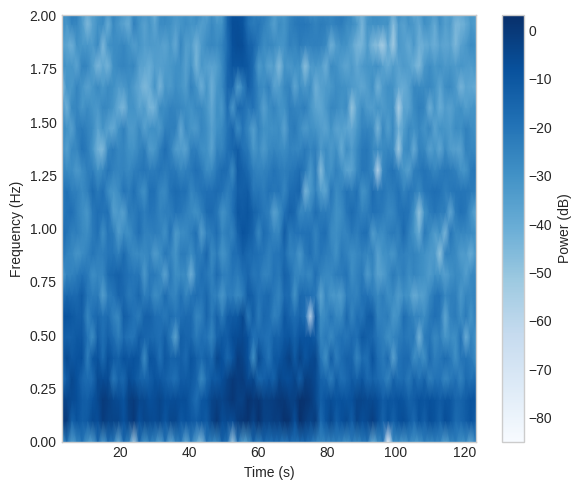

In [59]:
# --- FIGURE 4: SPECTROGRAM ANALYSIS ---

stable_file = '8s_sample_02.csv'

if os.path.exists(stable_file):
    data, fs = load_and_prep_file(stable_file)
    pca_sig = get_pca_signal(data)

    plt.figure(figsize=(6, 5))

    # Parameters for time-frequency resolution
    nperseg_spec = int(fs * 6)
    noverlap_spec = int(fs * 4.5)

    # Fix: Calculate nfft to be the next power of 2 >= nperseg
    # This prevents the ValueError if fs * 6 > 256
    nfft_spec = max(256, 2**int(np.ceil(np.log2(nperseg_spec))))

    f, t, Sxx = spectrogram(pca_sig, fs, nperseg=nperseg_spec, noverlap=noverlap_spec, nfft=nfft_spec)

    plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='Blues') # Added small epsilon to avoid log(0)

    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.ylim(0, 2.0)
    cbar = plt.colorbar()
    cbar.set_label('Power (dB)')

    plt.tight_layout()
    plt.savefig("Fig_04_Spectrogram.png", dpi=150)
    plt.show()

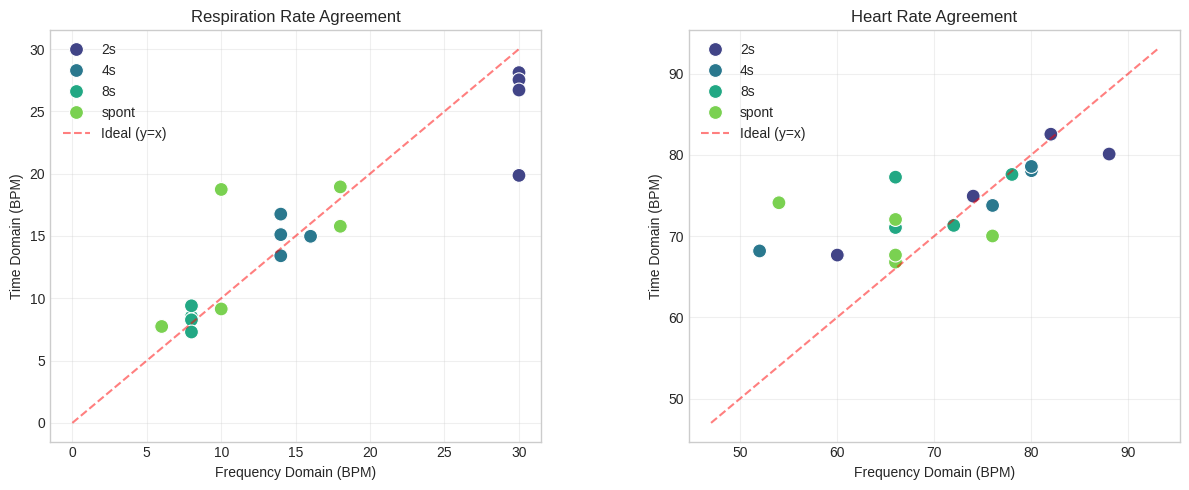

In [60]:
# --- FIGURE 5: METHOD COMPARISON (WELCH vs TIME DOMAIN) ---

if not df_results.empty:
    plt.figure(figsize=(12, 5))
    df_plot = df_results.reset_index()

    # Respiration Comparison
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df_plot, x='RR_Welch', y='RR_Time', hue='type', s=100, palette='viridis')

    max_val_rr = max(df_plot['RR_Welch'].max(), df_plot['RR_Time'].max())
    plt.plot([0, max_val_rr], [0, max_val_rr], 'r--', alpha=0.5, label='Ideal (y=x)')

    plt.title("Respiration Rate Agreement")
    plt.xlabel("Frequency Domain (BPM)")
    plt.ylabel("Time Domain (BPM)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Heart Rate Comparison
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=df_plot, x='HR_Welch', y='HR_Time', hue='type', s=100, palette='viridis')

    min_val_hr = min(df_plot['HR_Welch'].min(), df_plot['HR_Time'].min()) - 5
    max_val_hr = max(df_plot['HR_Welch'].max(), df_plot['HR_Time'].max()) + 5
    plt.plot([min_val_hr, max_val_hr], [min_val_hr, max_val_hr], 'r--', alpha=0.5, label='Ideal (y=x)')

    plt.title("Heart Rate Agreement")
    plt.xlabel("Frequency Domain (BPM)")
    plt.ylabel("Time Domain (BPM)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.savefig("Fig_05_Method_Comparison.png", dpi=150)
    plt.show()